# Segment Anything Model Test on Prostate MRI
https://segment-anything.com/

In [1]:
import re
import torch
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from lib.folder import FolderMg
from lib.sam_base import BasicSAM
print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu117
CUDA is available: True


In [2]:
!ls data/mri-prostate-slices-resample

1_029_10slices
10_213_13slices
11_543_18slices
12_244_14slices
2_837_19slices
3_947_10slices
4_920_19slices
6_624_17slices
7_709_20slices
8_258_16slices
9_825_15slices


In [3]:
sourceFolderName = "mri-prostate-slices-resample"
sourceDataPath = Path("data").joinpath(sourceFolderName)
destinationPath = Path("result").joinpath(sourceFolderName)
samModel = BasicSAM("vit_h")
sourceMg = FolderMg(sourceDataPath)

SAM Model set up finished.


In [4]:
slice_range = {
    "1": [2, 7],
    "2": [9, 12],
    "3": [3, 6],
    "4": [6, 12],
    "6": [6, 9],
    "7": [4, 15],
    "8": [5, 7],
    "9": [6, 9],
    "10": [3, 9],
    "11": [7, 10],
    "12": [4, 7],
}

Processing folders:
- 1_029_10slices
- 2_837_19slices
- 3_947_10slices
- 4_920_19slices
- 6_624_17slices
- 7_709_20slices
- 8_258_16slices
- 9_825_15slices
- 10_213_13slices
- 11_543_18slices
- 12_244_14slices
Finished


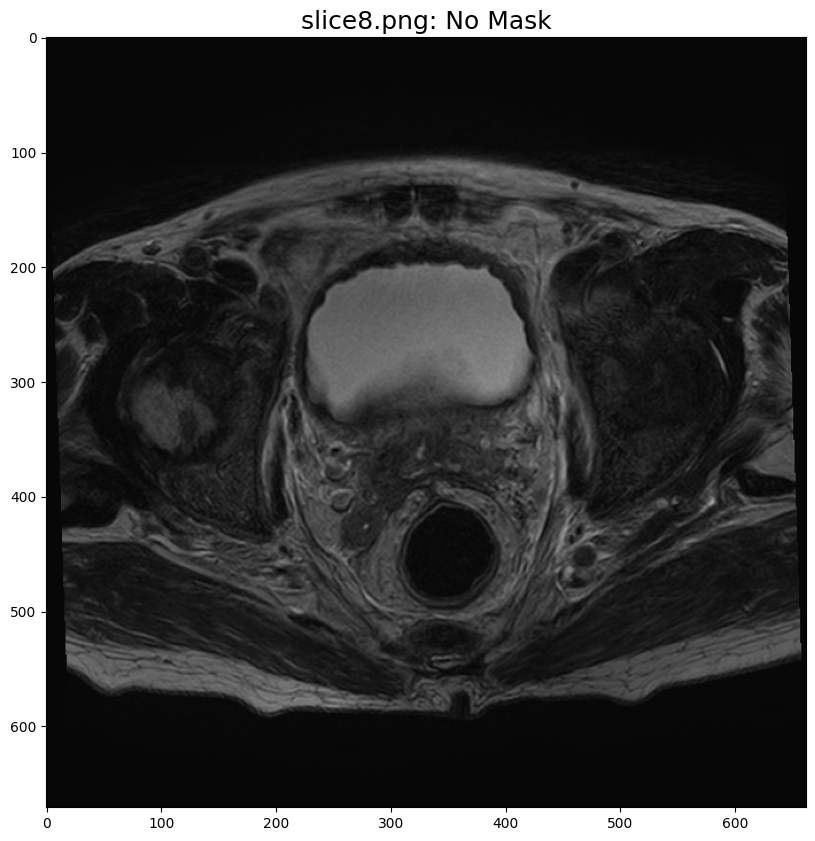

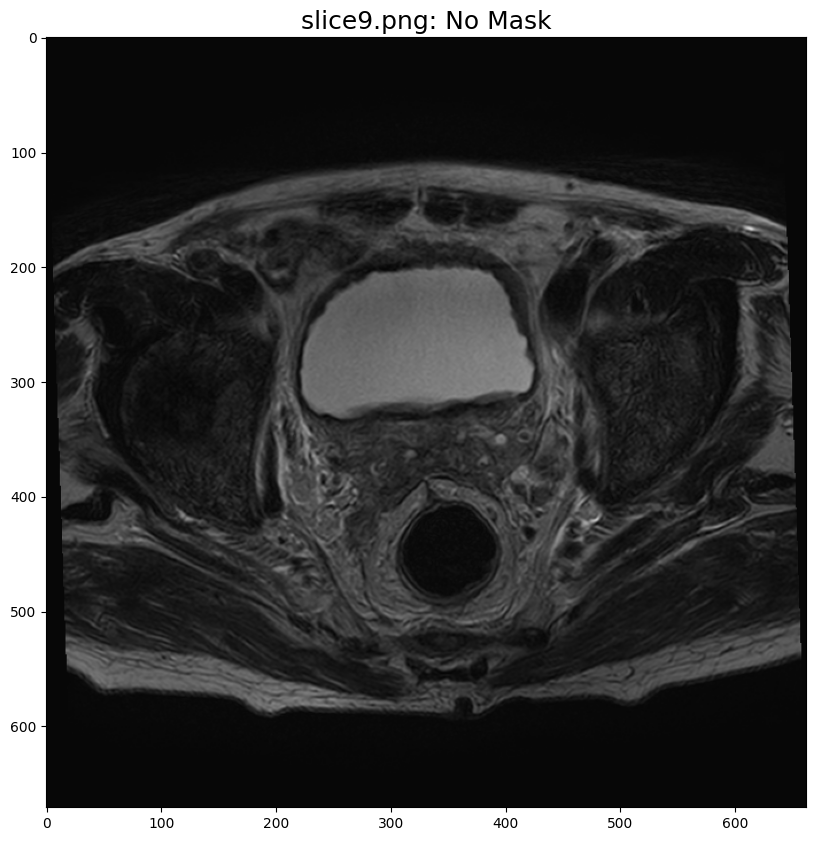

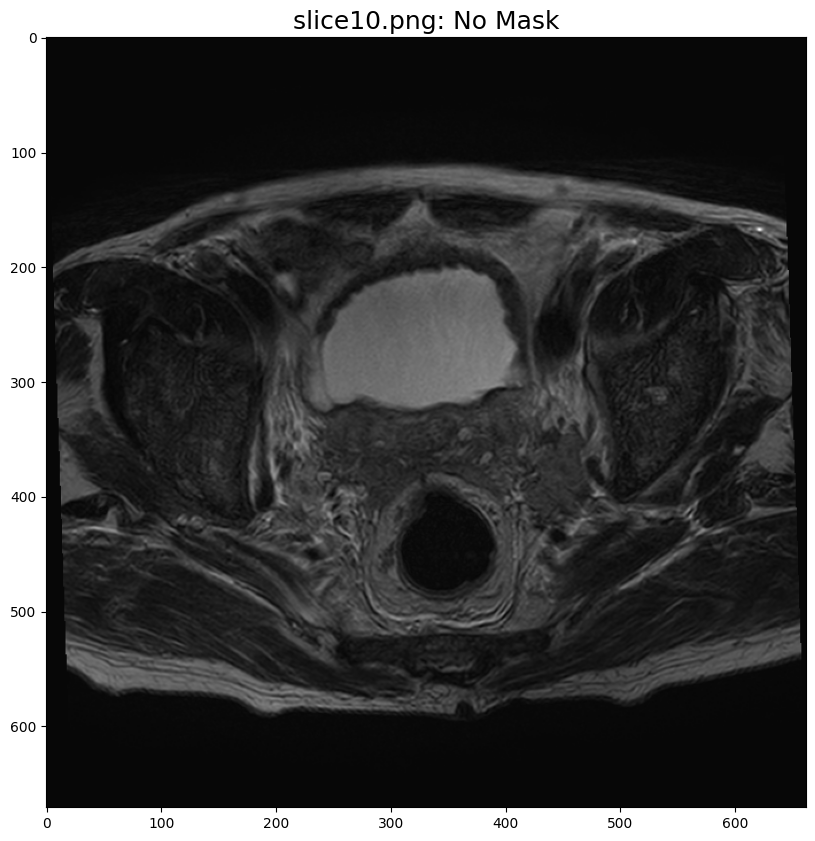

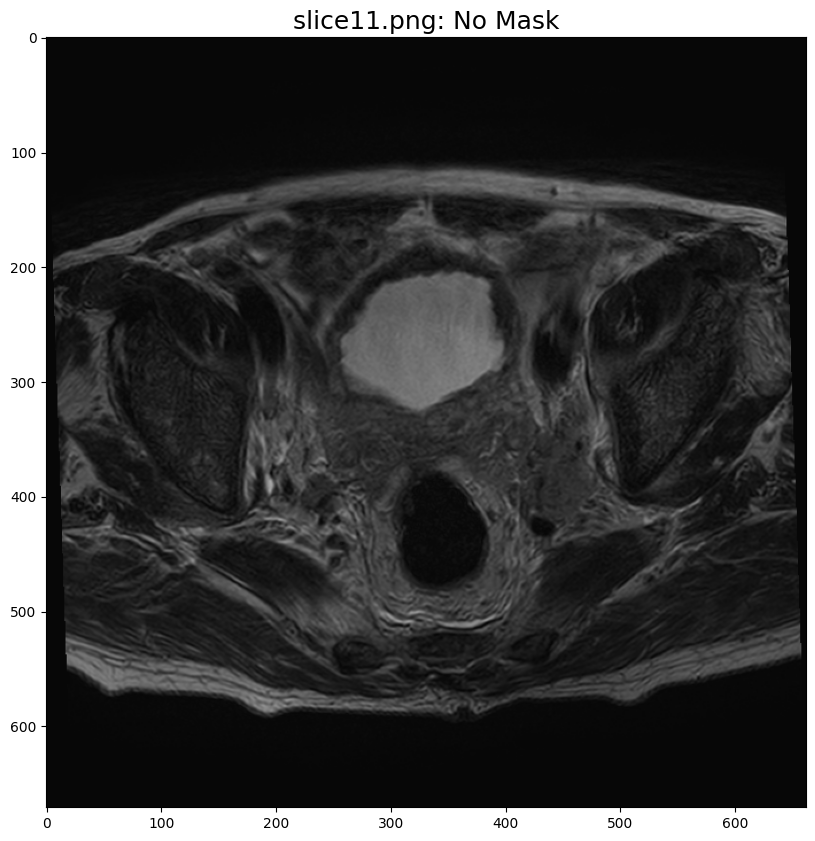

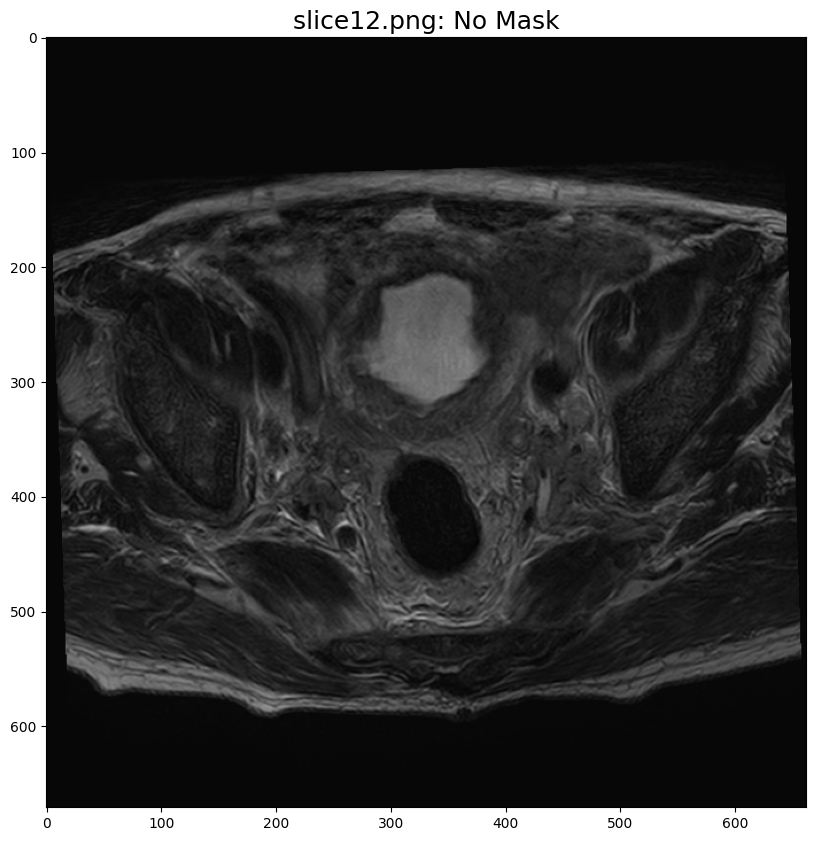

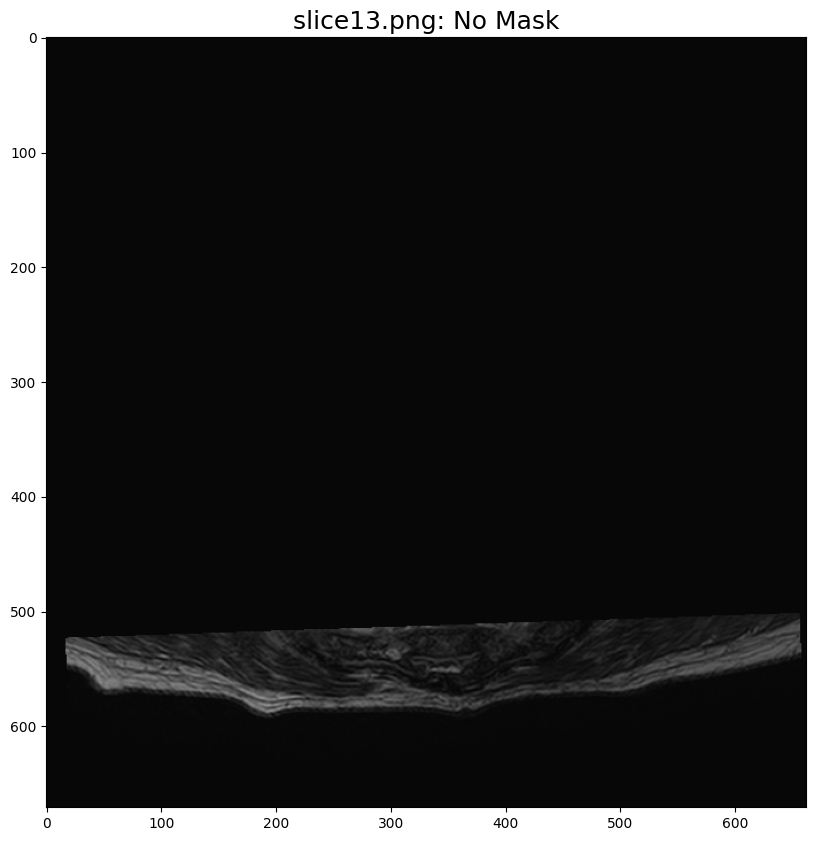

In [5]:
print("Processing folders:")
for fd in sourceMg.dirs:
    print(f"- {fd.name}")
    fdMg = FolderMg(fd)

    outputFolderPath = destinationPath.joinpath(f"{fd.name}")
    if not outputFolderPath.exists():
        outputFolderPath.mkdir(parents=True)
    fdIdx = re.search("([0-9]+)", fd.stem).group(0)
    # print(f"fdIdx:{fdIdx}")
    # middleFile = fdMg.files[int(fdMg.nFile / 2)]
    # figSavePath = outputFolderPath.joinpath(f"{middleFile.name}_mask_")
    # masks, scores = predictOneImg(middleFile, predictor, figSavePath, False)
    sliceSegResult = []
    for slice in fdMg.files:
        sliceIdx = int(re.search("([0-9]+)", slice.stem).group(0))
        figSavePath = outputFolderPath.joinpath(f"{slice.name}")
        if sliceIdx < slice_range[fdIdx][0] or sliceIdx > slice_range[fdIdx][1]:
            mask = samModel.skipPredictAndSaveEmpty(slice, figSavePath)
            sliceSegResult.append(mask.astype(int).squeeze())
            continue
        # print(
        #     f"stem:{slice.stem}"
        #     f"slice_range[fdIdx][0]: {slice_range[fdIdx][0]}, "
        #     f"slice_range[fdIdx][1]:{slice_range[fdIdx][1]}, "
        #     f"sliceIdx:{sliceIdx}"
        # )
        masks, scores = samModel.predictOneImg(slice, figSavePath, onlyFirstMask=True)
        sliceSegResult.append(masks[0].astype(int).squeeze())
    imgSize = (masks.shape[0], masks.shape[1], fdMg.nFile)  # x,y,z
    # imgSegResult = sitk.Image(masks[0].shape[0],masks[0].shape[1], fdMg.nFile, sitk.sitkUInt8)
    segImgArray = np.array([sliceSegResult]).astype(int).squeeze()
    segImg = sitk.GetImageFromArray(segImgArray)
    imgSavePath = destinationPath.joinpath(f"seg_{fd.name}.nii.gz")
    sitk.WriteImage(segImg, imgSavePath)
    plt.close("all")
print("Finished")